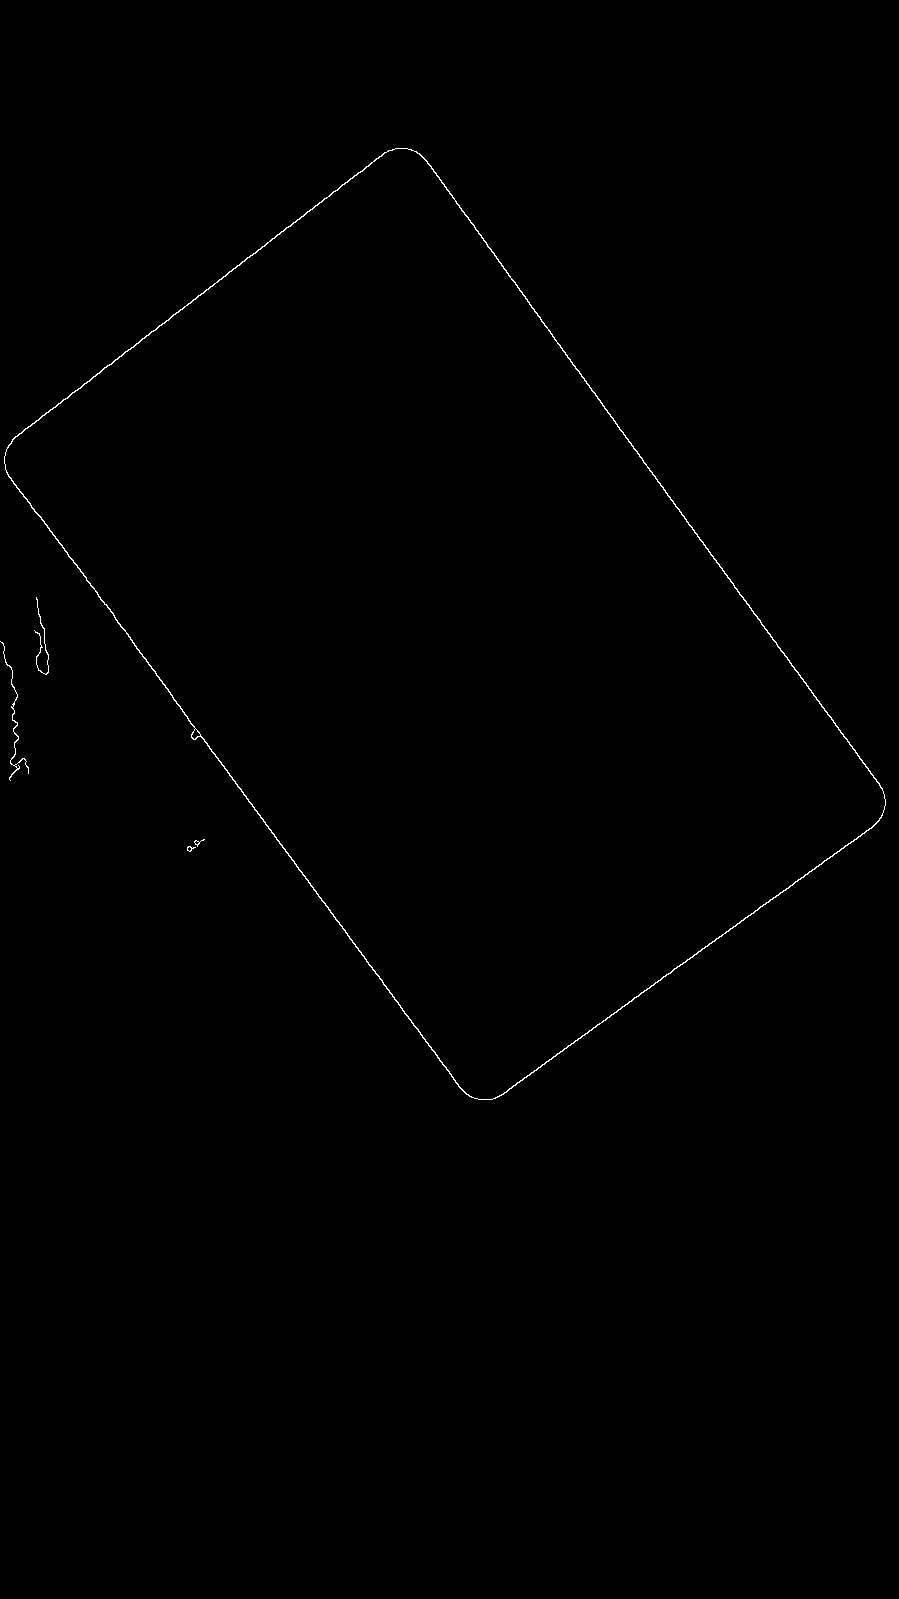

length of countours  9


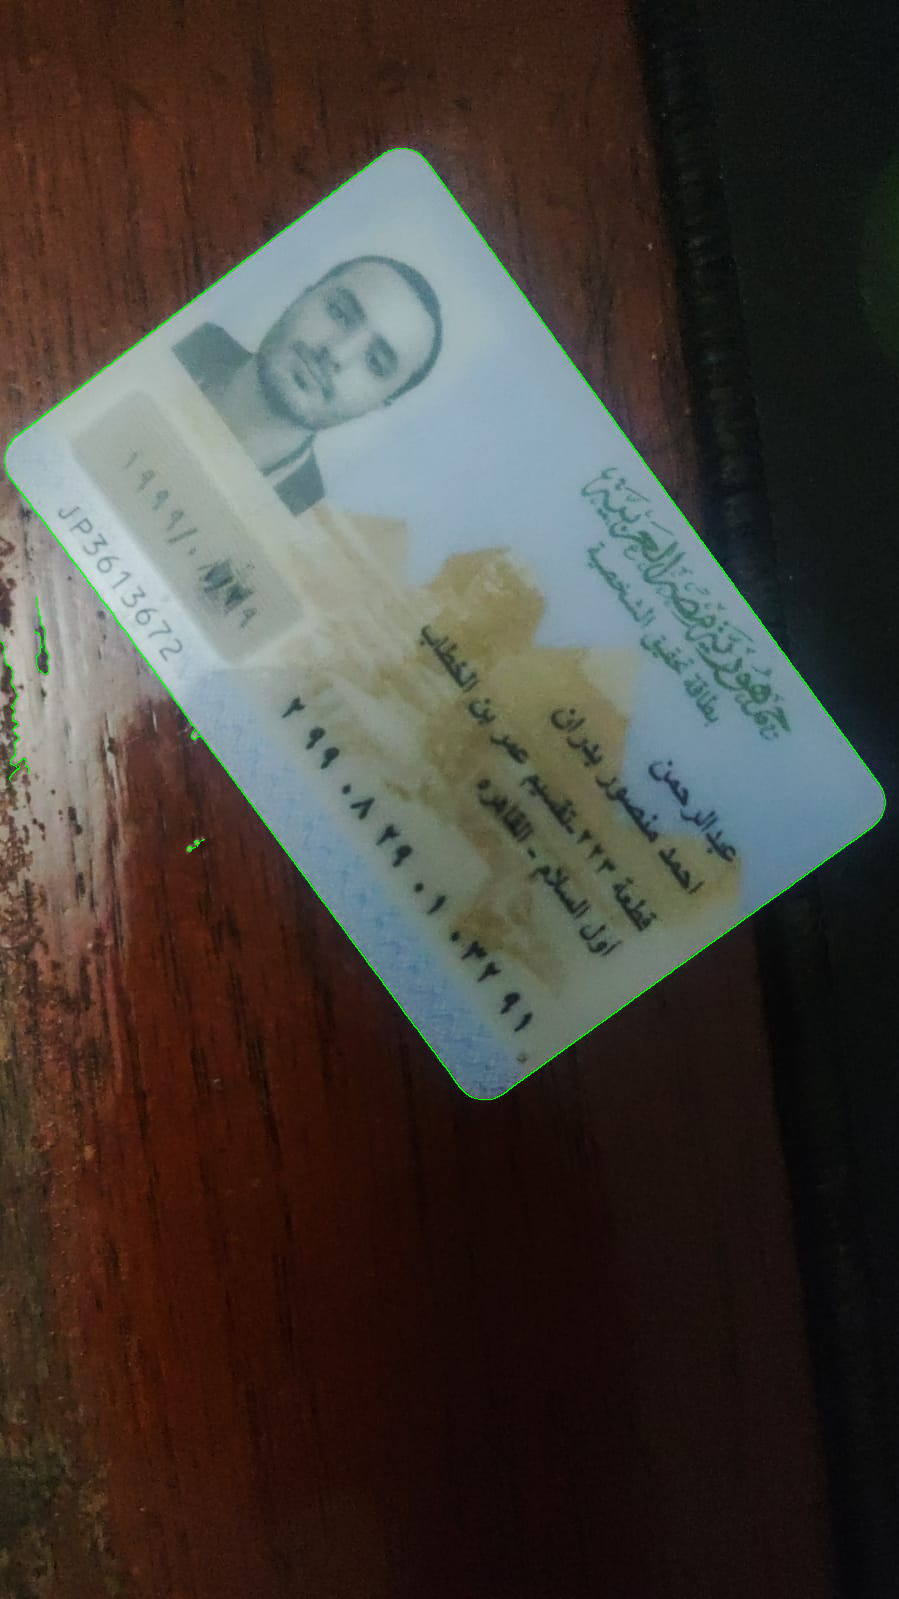

Screens found : 2
Screen Dimentions [882, 882]
Old Screen Dimentions filtered []
Screen Dimentions filtered [882, 882]


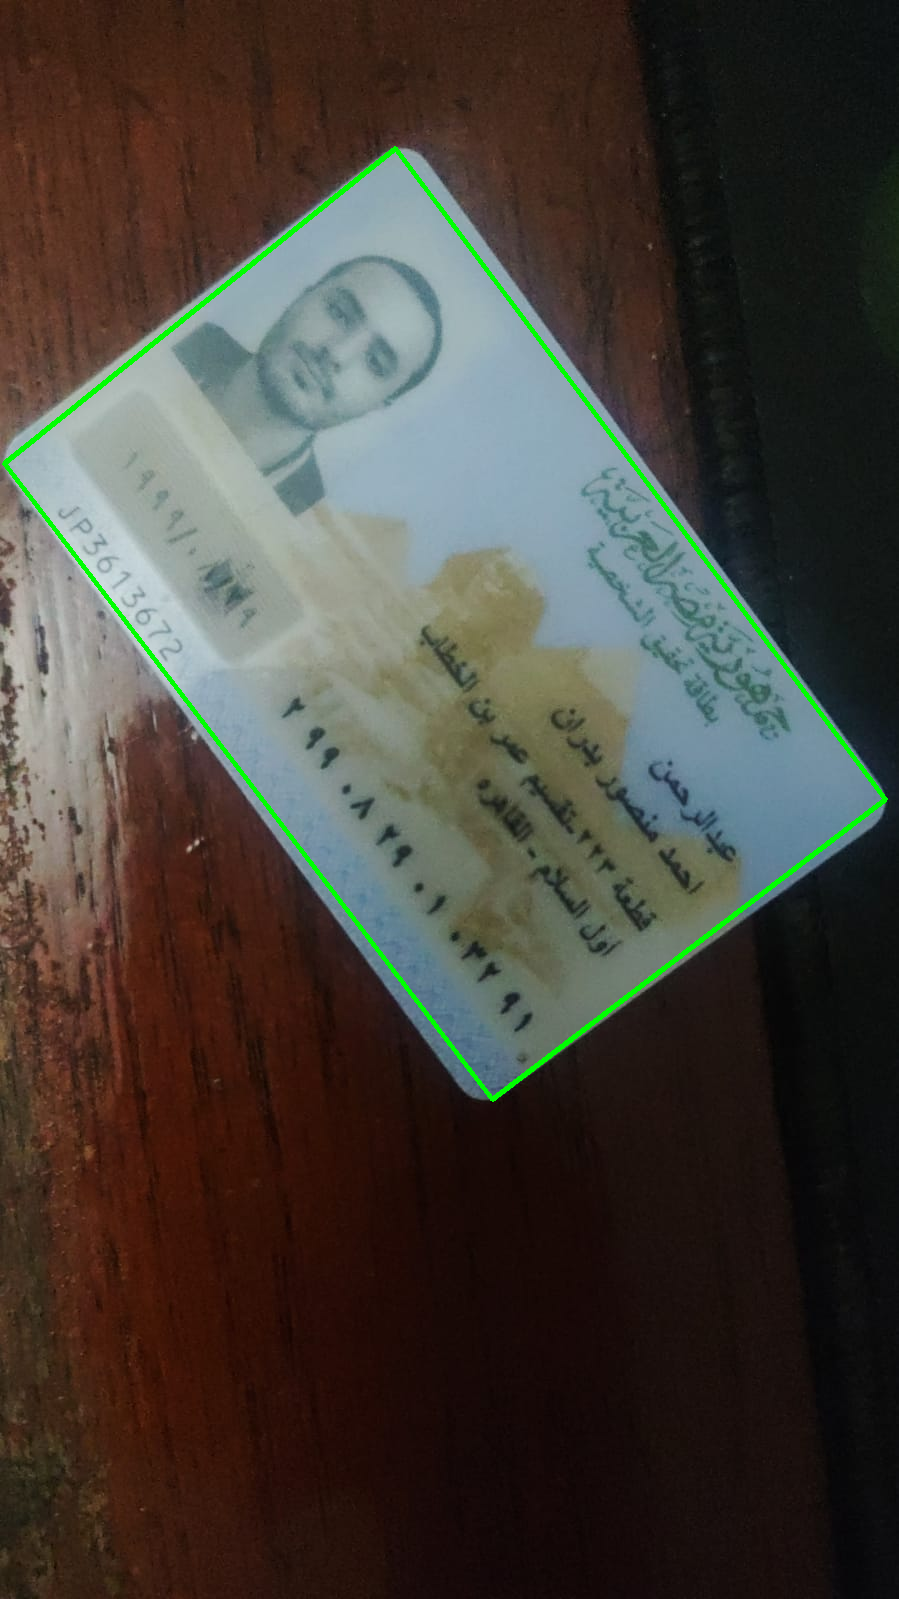

Found bill rectagle at  [[ 395  148]
 [   4  463]
 [ 492 1099]
 [ 885  799]]
[[   4.  463.]
 [ 395.  148.]
 [ 885.  799.]
 [ 492. 1099.]]


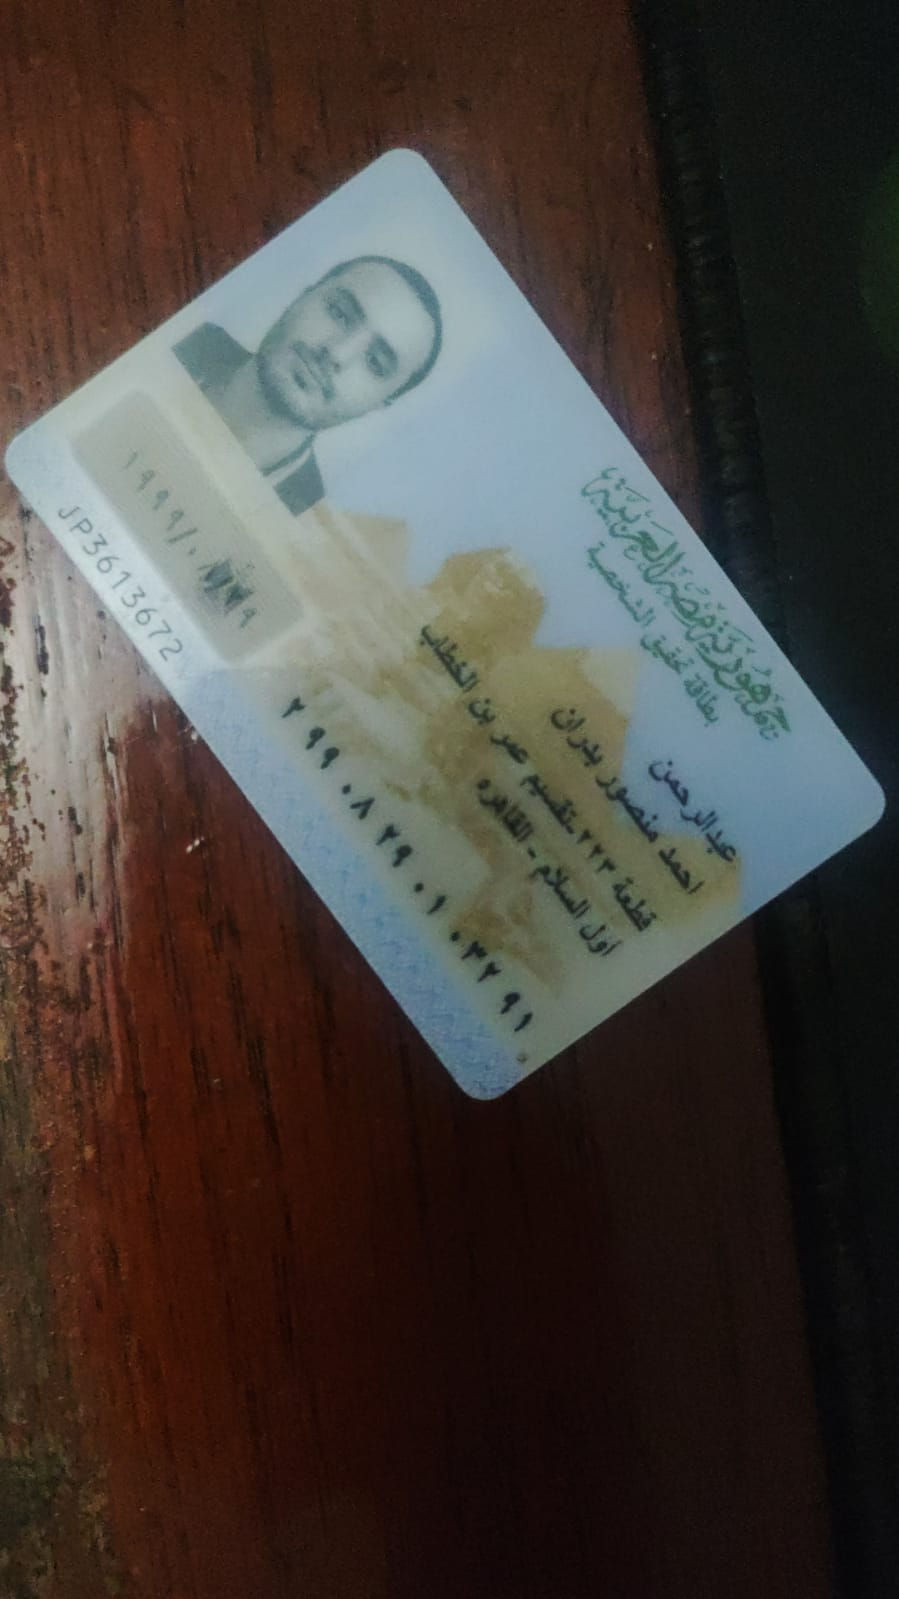

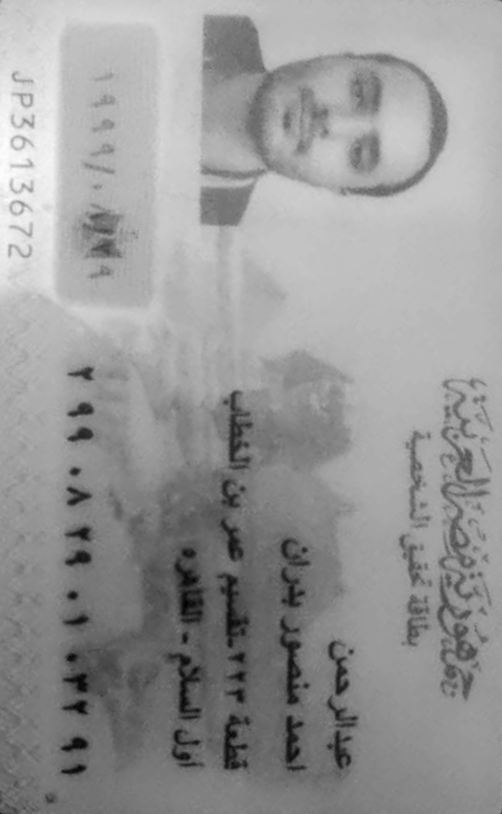

error: ignored

In [ ]:
import cv2
import imutils
import numpy as np
from skimage import exposure
from google.colab.patches import cv2_imshow

#function to order points to proper rectangle
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


#function to transform image to four points
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)

    # # multiply the rectangle by the original ratio
    # rect *= ratio

    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


#function to find two largest countours which ones are may be
#  full image and our rectangle edged object
def findLargestCountours(cntList, cntWidths):
    newCntList = []
    newCntWidths = []

    #finding 1st largest rectangle
    first_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[first_largest_cnt_pos])
    newCntWidths.append(cntWidths[first_largest_cnt_pos])

    #removing it from old
    cntList.pop(first_largest_cnt_pos)
    cntWidths.pop(first_largest_cnt_pos)

    #finding second largest rectangle
    seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[seccond_largest_cnt_pos])
    newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

    #removing it from old
    cntList.pop(seccond_largest_cnt_pos)
    cntWidths.pop(seccond_largest_cnt_pos)

    print('Old Screen Dimentions filtered', cntWidths)
    print('Screen Dimentions filtered', newCntWidths)
    return newCntList, newCntWidths


#driver function which identifieng 4 corners and doing four point transformation
def convert_object(image, screen_size = None, isDebug = False):

    # image = imutils.resize(image, height=300)
    # ratio = image.shape[0] / 300.0


    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)  # 11  //TODO 11 FRO OFFLINE MAY NEED TO TUNE TO 5 FOR ONLINE

    gray = cv2.medianBlur(gray, 5)
    edged = cv2.Canny(gray, 30, 400)

    if isDebug  : cv2_imshow(edged)
    # find contours in the edged image, keep only the largest
    # ones, and initialize our screen contour

    countours, hierarcy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    if isDebug : print('length of countours ', len(countours))

    imageCopy = image.copy()
    if isDebug : cv2_imshow(cv2.drawContours(imageCopy, countours, -1, (0, 255, 0), 1))


    # approximate the contour
    cnts = sorted(countours, key=cv2.contourArea, reverse=True)
    screenCntList = []
    scrWidths = []
    for cnt in cnts:
        peri = cv2.arcLength(cnt, True)  # cnts[1] always rectangle O.o
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        screenCnt = approx
        # print(len(approx))

        if (len(screenCnt) == 4):

            (X, Y, W, H) = cv2.boundingRect(cnt)
            # print('X Y W H', (X, Y, W, H))
            screenCntList.append(screenCnt)
            scrWidths.append(W)

        # else:
        #     print("4 points not found")

    print('Screens found :', len(screenCntList))
    print('Screen Dimentions', scrWidths)

    screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

    if not len(screenCntList) >=2: #there is no rectangle found
        return None
    elif scrWidths[0] != scrWidths[1]: #mismatch in rect
        return None

    if isDebug :   cv2_imshow(cv2.drawContours(image.copy(), [screenCntList[0]], -1, (0, 255, 0), 3))

    # now that we have our screen contour, we need to determine
    # the top-left, top-right, bottom-right, and bottom-left
    # points so that we can later warp the image -- we'll start
    # by reshaping our contour to be our finals and initializing
    # our output rectangle in top-left, top-right, bottom-right,
    # and bottom-left order
    pts = screenCntList[0].reshape(4, 2)
    print('Found bill rectagle at ', pts)
    rect = order_points(pts)
    print(rect)

    # apply the four point tranform to obtain a "birds eye view" of
    # the image
    warped = four_point_transform(image, pts)

    # convert the warped image to grayscale and then adjust
    # the intensity of the pixels to have minimum and maximum
    # values of 0 and 255, respectively
    warp = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warp = exposure.rescale_intensity(warp, out_range=(0, 255))

    # show the original and warped images
    if(isDebug):
        cv2_imshow(image)
        cv2_imshow(warp)
        cv2.waitKey(0)

    if(screen_size != None):
        return cv2.cvtColor(cv2.resize(warp, screen_size), cv2.COLOR_GRAY2RGB)
    else:
        return cv2.cvtColor(warp, cv2.COLOR_GRAY2RGB)


convert_object(cv2.imread('/content/WhatsApp Image 2023-01-10 at 06.23.42.jpeg'), isDebug=True)